# IMPORTANT
THIS CODE IS BASED ON TENSORFLOW-GPU. All visualisation can be run on tensorflow,but retraining the NN needs compatible CUDNN,CUDA and tensorflow-gpu.

# Summary
This code gives a short summary on the current progress for volatilities (last update: 24.04.2020).
Training: Parameters (a,b,g*,w,h0) to HNG-Volatility surface aswell as the inverse mapping.
For the used dataset (50.000 szenarios), each szenario is generated as followed:
Dataset in use: "norm" where extreme scenarios are filtered out
Grid: Maturities = [10:30:250] days and inv. Moneyness  K/S  = [0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.1].

1. Initialisation/ Preambel and Data Import:
This Initialisation will be used for everyfile to ensure the same conditions everytime!

In [1]:
import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from tensorflow.compat.v1.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import Reshape,InputLayer,Dense,Flatten, Conv2D,Conv1D, Dropout, Input,ZeroPadding2D,ZeroPadding1D,MaxPooling2D
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
#import matplotlib.ticker as mtick
#from scipy.optimize import minimize,NonlinearConstraint
#import matplotlib.lines as mlines
#import matplotlib.transforms as mtransforms
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
#from mpl_toolkits.mplot3d import Axes3D  
#from matplotlib import cm
import scipy
#import scipy.io
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
#import random
#import time
#import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import keras
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
## import data set
from config_9x9 import Nparameters,maturities,strikes,Nstrikes,Nmaturities,Ntest,Ntrain,Nval
from config_9x9 import xx,rates_train,rates_val,rates_test,ub,lb,diff,bound_sum
from config_9x9 import X_train,X_test,X_val,X_train_trafo,X_val_trafo,X_test_trafo,X_train_trafo2,X_val_trafo2,X_test_trafo2
# vola
from config_9x9 import yy,y_train,y_test,y_val,ub_vola,lb_vola,diff_vola,bound_sum_vola
from config_9x9 import y_train_trafo,y_val_trafo,y_test_trafo
from config_9x9 import y_train_trafo1,y_val_trafo1,y_test_trafo1
from config_9x9 import y_train_trafo2,y_val_trafo2,y_test_trafo2
# price
from config_9x9 import yy_price,y_train_price,y_test_price,y_val_price,ub_price,lb_price,diff_price,bound_sum_price
from config_9x9 import y_train_trafo_price,y_val_trafo_price,y_test_trafo_price
from config_9x9 import y_train_trafo1_price,y_val_trafo1_price,y_test_trafo1_price
from config_9x9 import y_train_trafo2_price,y_val_trafo2_price,y_test_trafo2_price
from config_9x9 import vega_train,vega_test,vega_val
# import custom functions #scaling tools
from config_9x9 import ytransform, yinversetransform,myscale,myinverse
#custom errors
from add_func_9x9 import root_mean_squared_error,root_relative_mean_squared_error,mse_constraint,rmse_constraint
#else
from add_func_9x9 import constraint_violation,pricing_plotter,plotter_autoencoder
tf.compat.v1.keras.backend.set_floatx('float64')  

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9992657033937588552
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13581283758
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8856555604315950778
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:73:00.0, compute capability: 6.1"
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14402557437913596287
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13581283758
locality {
  bus_id: 1
  links {
  }
}
incarnation: 315268970032931330
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:73:00.0, compute capability: 6.1"
]


Using TensorFlow backend.


# Volatility Pricing Kernel

Setup

In [8]:
NN1a = Sequential() 
NN1a.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1a.add(ZeroPadding2D(padding=(2, 2)))
NN1a.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1a.add(ZeroPadding2D(padding=(3,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(2,2)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,2),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(2,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(2,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1a.add(MaxPooling2D(pool_size=(2, 1)))
#NN1a.add(Dropout(0.25))
#NN1a.add(ZeroPadding2D(padding=(0,1)))
NN1a.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1a.add(MaxPooling2D(pool_size=(4, 1)))
NN1a.summary()
#setting
#NN1a.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
NN1a.compile(loss = "MAPE", optimizer = "adam",metrics=["MSE"])
NN1a.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#good num of epoch could be 350-(Ntotal/1000)

y_tmp_train = y_train_trafo1[:,:,[0,1,2,3,4,5],:]
y_tmp_val = y_val_trafo1[:,:,[0,1,2,3,4,5],:]
y_tmp_test= y_test_trafo1[:,:,[0,1,2,3,4,5],:]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = 50 ,restore_best_weights=True)
#NN1a.fit(X_train_trafo, y_tmp_train, batch_size=64, validation_data = (X_val_trafo, y_tmp_val), epochs = 1000, verbose = True, shuffle=1,callbacks=[es])
#NN1a.save_weights("vola_weights_noRate_9x9_a.h5")
NN1a.load_weights("vola_weights_noRate_9x9_a.h5")



NN1b = Sequential() 
NN1b.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1b.add(ZeroPadding2D(padding=(2, 2)))
NN1b.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1b.add(ZeroPadding2D(padding=(3,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(2,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,0)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,2),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(2,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(2,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1b.add(MaxPooling2D(pool_size=(2, 1)))
#NN1b.add(Dropout(0.25))
#NN1b.add(ZeroPadding2D(padding=(0,1)))
NN1b.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1b.add(MaxPooling2D(pool_size=(4, 1)))
NN1b.summary()
#setting
#NN1b.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
#NN1b.compile(loss = "MAPE", optimizer = "adam",metrics=["MSE"])
NN1b.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#good num of epoch could be 350-(Ntotal/1000)

y_tmp_train = y_train_trafo1[:,:,[5,6,7,8],:]
y_tmp_val = y_val_trafo1[:,:,[5,6,7,8],:]
y_tmp_test= y_test_trafo1[:,:,[5,6,7,8],:]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = 50 ,restore_best_weights=True)
# fit model
#NN1b.fit(X_train_trafo, y_tmp_train, batch_size=64, validation_data = (X_val_trafo, y_tmp_val), epochs = 1000, verbose = True, shuffle=1,callbacks=[es])


#NN1b.fit(X_train_trafo, y_train_trafo1, batch_size=64, validation_data = (X_val_trafo, y_val_trafo1), epochs = 100, verbose = True, shuffle=1)
#NN1b.save_weights("vola_weights_noRate_9x9_b.h5")
NN1b.load_weights("vola_weights_noRate_9x9_b.h5")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_36 (ZeroPaddi (None, 9, 5, 1)           0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 7, 5, 32)          128       
_________________________________________________________________
zero_padding2d_37 (ZeroPaddi (None, 13, 7, 32)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 12, 6, 32)         4128      
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 6, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_38 (ZeroPaddi (None, 10, 9, 32)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 9, 8, 32)         

Results 

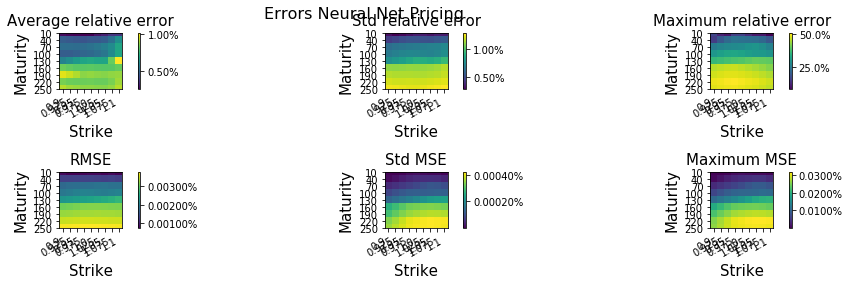

([array([4.90420e+04, 3.20535e+05, 2.16866e+05, 1.15528e+05, 5.30370e+04,
         1.99680e+04, 6.96100e+03, 1.93400e+03, 2.79000e+02, 1.10000e+01]),
  array([5.09140e+04, 3.18136e+05, 2.14994e+05, 1.16196e+05, 5.40270e+04,
         2.05500e+04, 7.06200e+03, 1.91700e+03, 3.36000e+02, 2.90000e+01])],
 array([0.02512137, 0.07461661, 0.12411186, 0.1736071 , 0.22310234,
        0.27259759, 0.32209283, 0.37158807, 0.42108332, 0.47057856,
        0.52007381]),
 <a list of 2 Lists of Patches objects>)

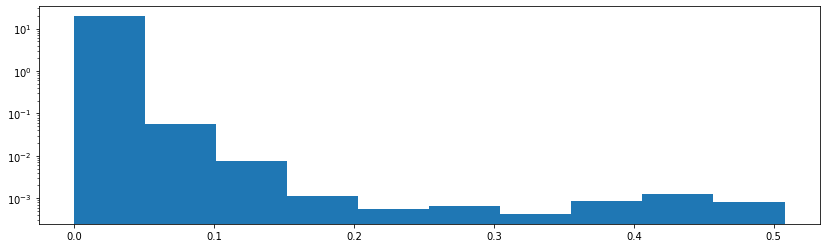

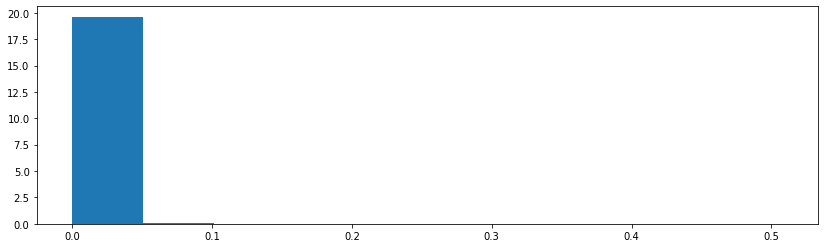

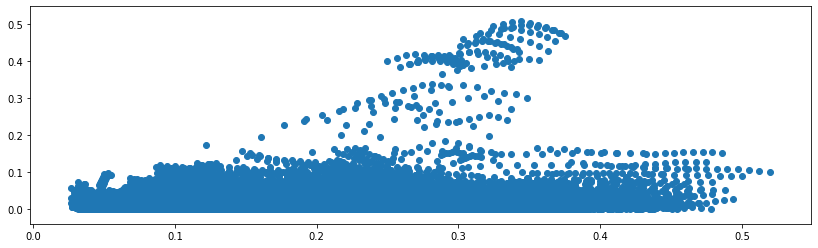

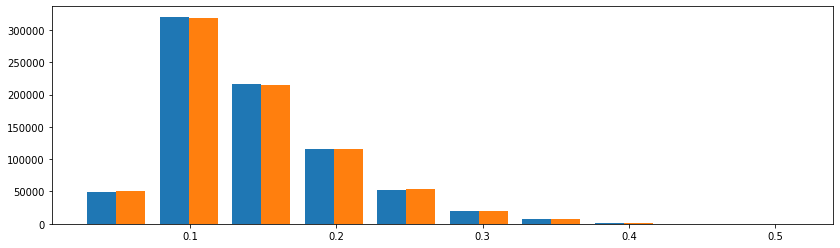

In [14]:
# The following plots show the performance on the testing set
S0=1.
prediction_a   = NN1a.predict(X_test_trafo).reshape((Ntest,6,Nstrikes))
prediction_b   = NN1b.predict(X_test_trafo).reshape((Ntest,4,Nstrikes))
prediction = np.concatenate((prediction_a[:,[0,1,2,3,4],:],prediction_b[:,[0,1,2,3],:]),axis =1)
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))

#plots
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)
plt.figure(figsize=(14,4))
plt.hist(err_rel_mat.flatten(),log=True,density =True)
plt.figure(figsize=(14,4))
plt.hist(err_rel_mat.flatten(),density =True)
plt.figure(figsize=(14,4))
plt.scatter(y_test_re.flatten(),err_rel_mat.flatten())
plt.figure(figsize=(14,4))
plt.hist((prediction.flatten(),y_test_re.flatten()))

# 3. CNN as  Decoder/Inverse Mapping / Calibration:

Setup

In [15]:
NN2 = Sequential() 
NN2.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(MaxPooling2D(pool_size=(2, 2)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Flatten())
NN2.add(Dense(Nparameters,activation = 'linear',use_bias=True))
NN2.summary()
#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
NN2.compile(loss =mse_constraint(0.75), optimizer = "adam",metrics=["MAPE", "MSE"])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = 50 ,restore_best_weights=True)
#history = NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2), epochs=1000, verbose = True, shuffle=1,callbacks = [es])
#NN2.save_weights("calibrationweights_vola_9x9.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN2.load_weights("calibrationweights_vola_9x9.h5")#id_3283354135d44b67_data_price_norm_231046clean


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 7, 7, 64)          640       
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 6, 6, 64)          16448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 2, 2, 64)          16448     
_________________________________________________________________
zero_padding2d_68 (ZeroPaddi (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 3, 3, 64)          16448     
_________________________________________________________________
zero_padding2d_69 (ZeroPaddi (None, 5, 5, 64)        

Results

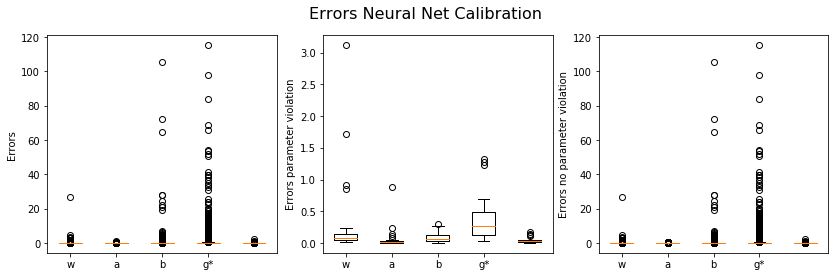

violation error mean in %: [33.27014405  6.71017744  8.39362433 38.64202325  4.39064437]
no violation error mean in %: [ 3.3443358   1.97018714 12.35806947 47.17579072  2.74123171]
violation error median in %: [ 7.50403878  1.10818784  6.25627797 26.22944262  3.36090448]
no violation error median in %: [ 1.75781617  1.45334094  4.8886475  10.76269476  2.23778138]
error mean in %: [ 3.42161555  1.98242759 12.34783177 47.15375331  2.74549112]
error median in %: [ 1.76210881  1.45326402  4.88908484 10.78545605  2.23899774]


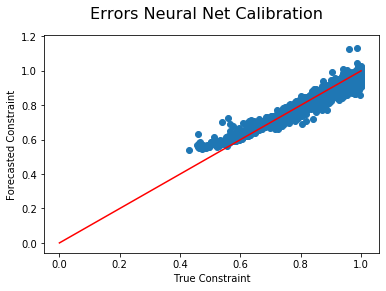

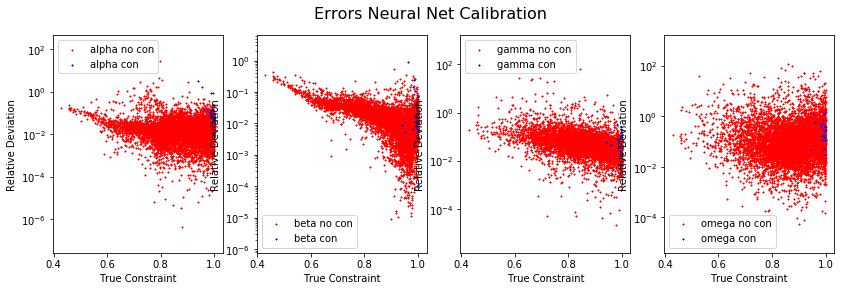

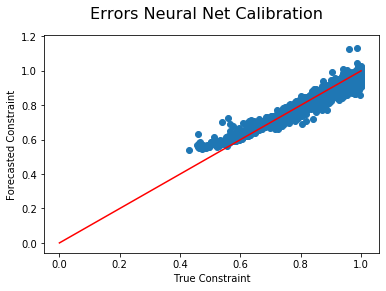

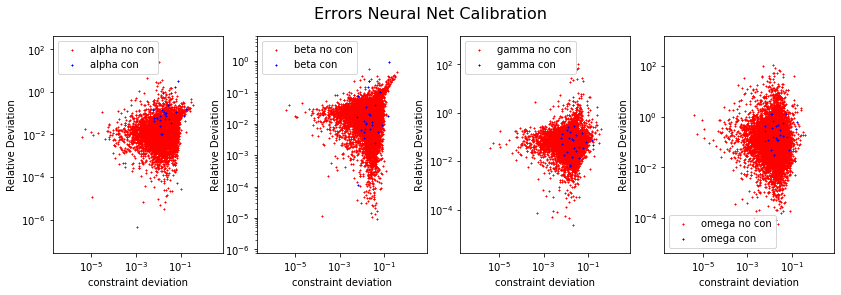

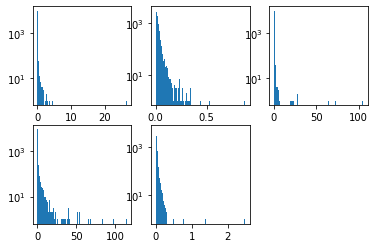

In [16]:
from add_func_9x9 import calibration_plotter
prediction_calibration = NN2.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])
dict_params ={"params_real":X_test, "params_NN":prediction_invtrafo,"rates":rates_test}
scipy.io.savemat("id_dfc18d626cbb42f1_calibrationNN.mat",dict_params)
#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)
plt.figure()
plt.subplot(2,3,1)
plt.yscale("log")
plt.hist(error[:,0],bins=100)
plt.subplot(2,3,2)
plt.yscale("log")
plt.hist(error[:,1],bins=100)
plt.subplot(2,3,3)
plt.yscale("log")
plt.hist(error[:,2],bins=100)
plt.subplot(2,3,4)
plt.yscale("log")
plt.hist(error[:,3],bins=100)
plt.subplot(2,3,5)
plt.yscale("log")
plt.hist(error[:,4],bins=100)
plt.show()

# 4. Autoencoder  

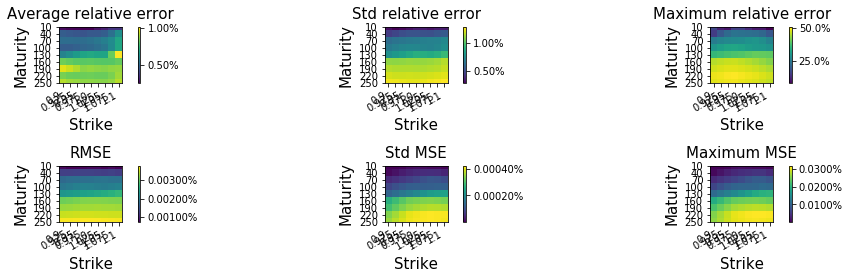

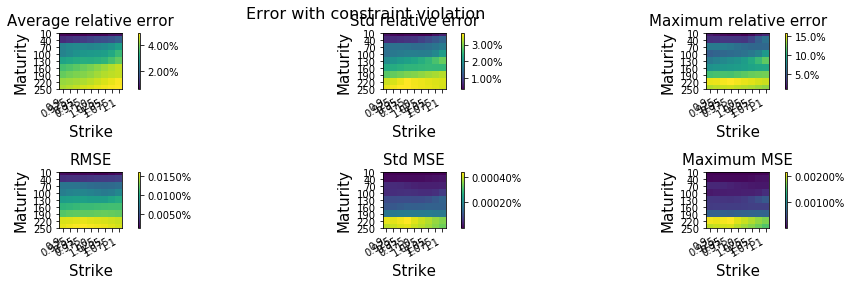

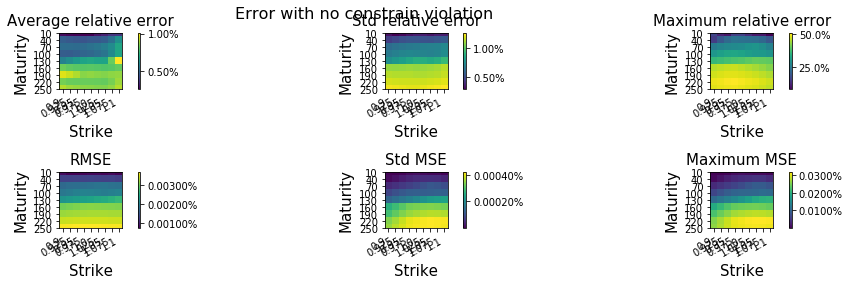

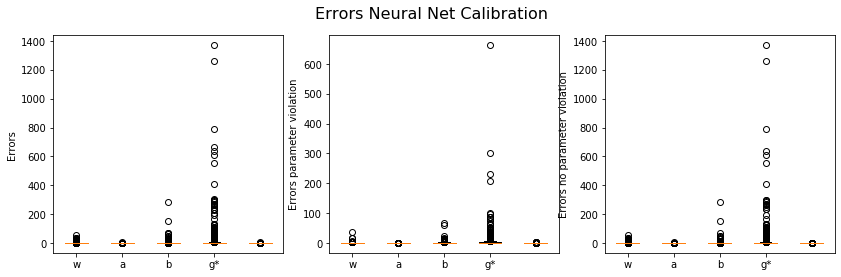

violation error mean in %: [ 62.89184325  17.62582586 112.20055801 675.67127399  40.02189351]
no violation error mean in %: [ 34.85832327  10.51785839  30.47985336 348.44622143  13.16620651]
violation error median in %: [ 45.61096628  14.00563917  36.069811   138.03182832  31.34268925]
no violation error median in %: [ 12.81169286   6.7452677   11.55595988 106.56260526   9.12659651]
error mean in %: [ 36.81293808  11.01345575  36.17776428 371.26172711  15.03869785]
error median in %: [ 14.04804079   7.03915337  12.34360354 107.82181469   9.8273564 ]


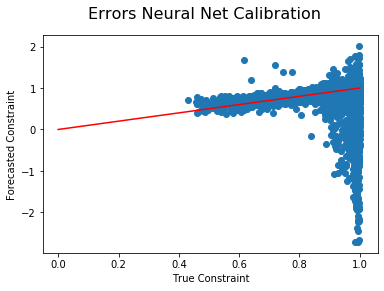

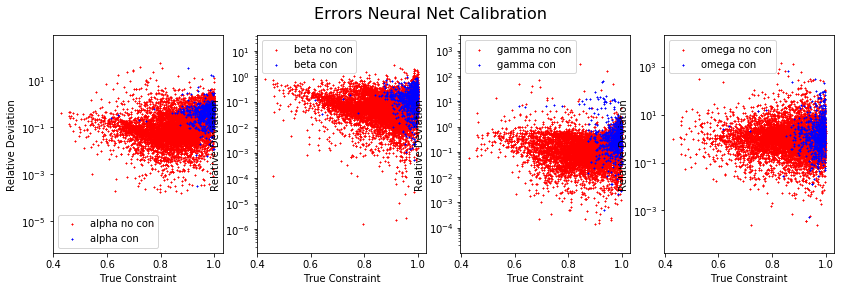

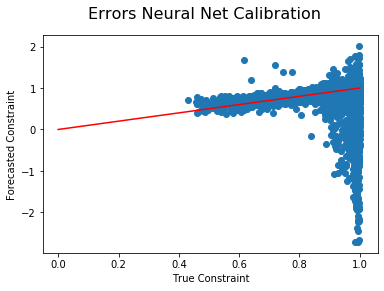

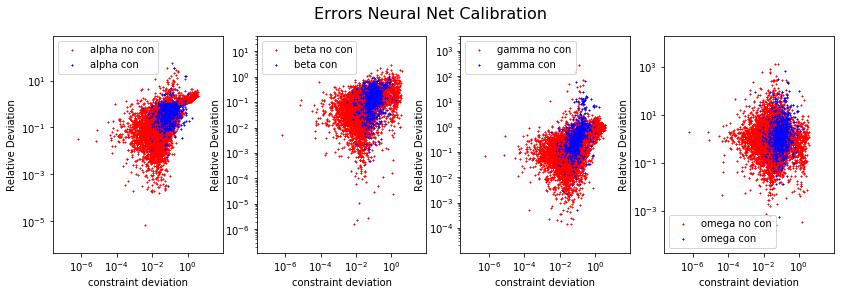

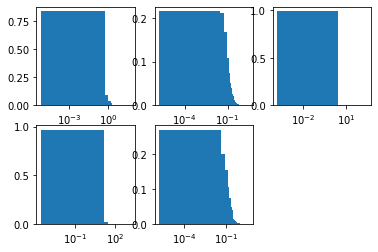

In [17]:
def autoencoder_surface(nn2,nn1):
    def autoencoder_predict(y_values):
        prediction = nn2.predict(y_values)
        prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
        forecast = nn1.predict(prediction_trafo).reshape((Ntest,Nmaturities,Nstrikes))
        return forecast
    return autoencoder_predict



forecast_a   = NN1a.predict(prediction_invtrafo.reshape((Ntest,Nparameters,1,1))).reshape((Ntest,6,Nstrikes))
forecast_b   = NN1b.predict(prediction_invtrafo.reshape((Ntest,Nparameters,1,1))).reshape((Ntest,4,Nstrikes))
auto_enc_surface = np.concatenate((prediction_a[:,[0,1,2,3,4],:],prediction_b[:,[0,1,2,3],:]),axis =1)


#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(auto_enc_surface,y_true_test,y_test,testing_violation,testing_violation2)



def autoencoder_params(nn1,nn2):
    def autoencoder_predict(x_values):
        prediction = nn1.predict(x_values)
        prediction_trafo = prediction.reshape((Ntest,Nmaturities,Nstrikes))
        forecast = nn2.predict(prediction_trafo)
        return forecast
    return autoencoder_predict



auto_enc_params =NN2.predict(prediction.reshape((Ntest,Nmaturities,Nstrikes,1)))
auto_enc_params_invtrafo =  np.array([myinverse(x) for x in auto_enc_params])
error_au,err1_au,err2_au,vio_error_au,vio_error2_au,c_au,c2_au,testing_violation_au,testing_violation2_au = calibration_plotter(auto_enc_params,X_test_trafo2,X_test)
plt.figure()
plt.subplot(2,3,1)
#plt.yscale("log")
plt.xscale("log")
plt.hist(error_au[:,0],bins=100,weights=np.zeros_like(error_au[:,0]) + 1. / error_au[:,0].size)
plt.subplot(2,3,2)
#plt.yscale("log")
plt.xscale("log")
plt.hist(error_au[:,1],bins=100,weights=np.zeros_like(error_au[:,0]) + 1. / error_au[:,0].size)
plt.subplot(2,3,3)
#plt.yscale("log")
plt.xscale("log")
plt.hist(error_au[:,2],bins=100,weights=np.zeros_like(error_au[:,0]) + 1. / error_au[:,0].size)
plt.subplot(2,3,4)
#plt.yscale("log")
plt.xscale("log")
plt.hist(error_au[:,3],bins=100,weights=np.zeros_like(error_au[:,0]) + 1. /error_au[:,0].size)
plt.subplot(2,3,5)
#plt.yscale("log")
plt.xscale("log")
plt.hist(error_au[:,4],bins=100,weights=np.zeros_like(error_au[:,0]) + 1. / error_au[:,0].size)
plt.show()